# <center>Multi-Sensor DiffuserCam: 2D Recon Performance</center>
<center>_Nico Deshler & Kristina Monakhova_<center>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as LAlg
import os

from PIL import Image
import scipy
import imageio
import scipy.io as sio
import scipy.ndimage.filters as sf
import numpy.fft as fft

plt.rcParams['figure.figsize'] = [10, 10] # define plot size

# 1) Setup Instructions

In the cell below...
- Set num_sources to a whole number {n = [1, 10]} to load in data from a simulated scene with n point sources
- Set num_sensors to a whole number to select 
- set sensor_pix to a 1x2 numpy array containing the desired sensor size

- Set iters to the number of FISTA iterations desired for the reconstruction
- Set applyGausssFilt boolean and sigma to relax conditions of the L2-Norm 
- Set sensor_scaling to a 1xn numpy array containing the scaling factors to multiply the sensor size for each iteration of the L2-norm calculation

The entire script is now ready to run!

Note:
_For all simulated image data in this demo, the point sources were positioned randomly on a plane located a distance of 50mm axially from the diffuser._

(<matplotlib.axes._subplots.AxesSubplot at 0x9e607b8>,
 Text(0.5,1,'Prototype Measurement'))

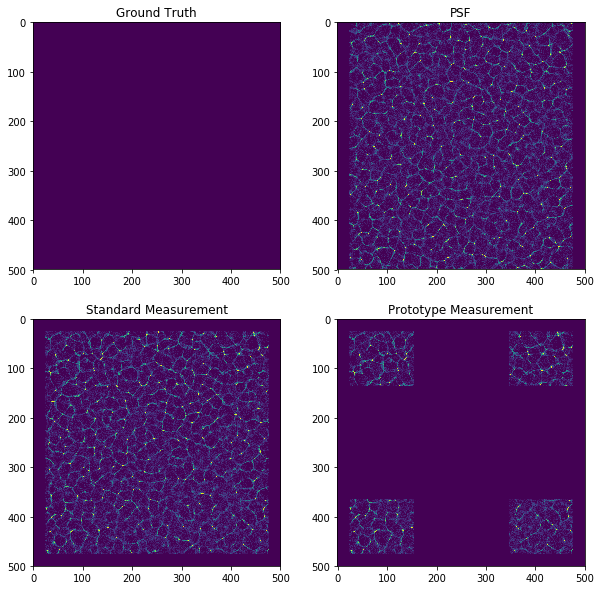

In [2]:
# Sensor and Scene Variables
num_sources = 1;
num_sensors = 2;
sensor_pix = np.array([100,100])
#sensor_pix = np.array([112, 154]) # True dimensions of the prototype sensors

# Reconstruction and L2-Norm Variables
iters = 200
applyGaussFilt = True 
sigma = 3 
sensor_scaling = np.linspace(1,2.5,5)


# Image Files
path = 'Prototype 2D Recon/2DScenes/num_srcs_' + str(num_sources) + '/'

def imgPrep(imname):
    im = Image.open(path + imname)
    im = np.array(im, dtype='float32')
    im = im/np.max(im)
    return im

ground_truth = imgPrep('ground_truth.png')
psf = imgPrep('PSF.png')
reg_measurement = imgPrep('std_measurement.png')
Proto_measurement = imgPrep('ms_measurement.png')

plt.subplot(2,2,1), plt.imshow(ground_truth), plt.title('Ground Truth')
plt.subplot(2,2,2), plt.imshow(psf), plt.title('PSF')
plt.subplot(2,2,3), plt.imshow(reg_measurement), plt.title('Standard Measurement')
plt.subplot(2,2,4), plt.imshow(Proto_measurement), plt.title('Prototype Measurement')

# 2) All Functions

In [3]:
# Returns a masked version of the image.
# dim_sensors and spacing are used to determine
# how the appropriate columns of the image will
# be deleted.
def maskIm(im, dim_sensors, num_sensors): 
    imDim = np.shape(im)
    spacing = np.floor((imDim - dim_sensors * num_sensors)/num_sensors)
    if spacing[0] < 0 or spacing[1] < 0:
        raise Exception("Sensors overlap! Consider reducing sensor size or number of sensors.")
    
    # Make binary sensor matrix with zero padding for spacing
    sensor = np.ones(dim_sensors)
    padR = int(spacing[0]/2)    
    padC = int(spacing[1]/2)
    sensor = np.pad(sensor, ((padR,padR),(padC,padC)), 'constant', constant_values = 0)
    maskRow = sensor
  
    i,j = 1,1
    
    # Build a mask row by stacking sensors horizontally
    while j < num_sensors:
        maskRow = np.hstack((maskRow, sensor))
        j = j + 1
      
    # Build the mask by stacking mask rows vertically 
    mask = maskRow
    while i < num_sensors:
        mask = np.vstack((mask, maskRow))
        i = i + 1
    
    # Enforce dimensional equality between mask and input image
    mskDim = np.shape(mask)
    fill = np.subtract(imDim, mskDim)
    mask = np.pad(mask, ((0,int(fill[0])), (0,int(fill[1]))), 'constant', constant_values = 0)    
    
    return np.multiply(im, mask)

In [4]:
# forward model 
def fi(x):
    x = np.pad(x, PADDINGi, 'constant').astype('complex64')
    x = np.fft.fft2(x)/NNi                                          # FFT 
    x = Hi*x                                                        # Multiply by H
    x = np.fft.ifft2(x)*NNi                                         # Inverse FFT
    x = np.fft.ifftshift(x)                                         # IFFTSHIFT
    x = x[C1i:C2i, C1i:C2i]                                            # Crop 
    return np.abs(x)

In [5]:
# forward model 
def f(x):
    x = np.pad(x, PADDING, 'constant').astype('complex64')
    x = np.fft.fft2(x)/NN                                          # FFT 
    x = H*x                                                        # Multiply by H
    x = np.fft.ifft2(x)*NN                                         # Inverse FFT
    x = np.fft.ifftshift(x)                                        # IFFTSHIFT
    x = x[C1:C2, C1:C2]                                            # Crop 
    return np.abs(x)

In [6]:
# Define Constants 
DIMSi = psf.shape[0]                                    # Image Dimensions
PAD_SIZEi = int(DIMSi/2)                                # Pad size
C1i = PAD_SIZEi; C2i = PAD_SIZEi + DIMSi                # Crop indices 
PADDINGi = ([PAD_SIZEi, PAD_SIZEi], [PAD_SIZEi, PAD_SIZEi])
NNi = np.sqrt(DIMSi*2*DIMSi*2)


psf_pad = np.pad(psf, PADDINGi, 'constant')


DIMS = psf_pad.shape[0]                               # Image Dimensions
PAD_SIZE = int(DIMS/2)                                # Pad size
C1 = PAD_SIZE; C2 = PAD_SIZE + DIMS                   # Crop indices 
PADDING = ([PAD_SIZE, PAD_SIZE], [PAD_SIZE, PAD_SIZE])
NN = np.sqrt(DIMS*2*DIMS*2)



In [7]:
def grad(Hadj, H, vk, b, crop, pad):
    Av = calcA(H, vk, crop)
    diff = Av - b
    return np.real(calcAHerm(Hadj, diff, pad))
def fista_update(vk, tk, xk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    x_k1 = xk
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    xk = proj(vk)
    t_k1 = (1+np.sqrt(1+4*tk**2))/2
    vk = xk+(tk-1)/t_k1*(xk - x_k1)
    tk = t_k1
    
    return vk, tk, xk
def calcA(H, vk, crop):
    Vk = fft.fft2(vk)/NN
    return crop(fft.ifftshift(fft.ifft2(H*Vk)*NN))
def calcAHerm(Hadj, diff, pad):
    xpad = pad(diff)
    X = fft.fft2(xpad)/NN
    return fft.ifftshift(fft.ifft2(Hadj*X)*NN)
def grad_descent(h, b):
    H, Hadj, v, utils = initMatrices(h)
    crop = utils[0]
    pad = utils[1]
        
    alpha = np.real(2/(np.max(Hadj * H)))
    iterations = 0
     
    def non_neg(xi):
        xi[xi<0] = 0
        return xi

    proj = non_neg

    parent_var = [H, Hadj, b, crop, pad, alpha, proj]
    
    vk = v
    
    #### uncomment for FISTA update ################
    tk = 1
    xk = v
    ################################################
        
    for iterations in range(iters):
        # uncomment for FISTA update
        vk, tk, xk = fista_update(vk, tk, xk, parent_var)

        if iterations % 10 == 0:
            print("FISTA iter: " + str(iterations))

    return non_neg(crop(vk)) 
    

In [8]:
def initMatrices(h):
    pixel_start = (np.max(h) + np.min(h))/2
    x = np.ones(h.shape)*pixel_start

    init_shape = h.shape
    padded_shape = [nextPow2(2*n - 1) for n in init_shape]
    starti = (padded_shape[0]- init_shape[0])//2
    endi = starti + init_shape[0]
    startj = (padded_shape[1]//2) - (init_shape[1]//2)
    endj = startj + init_shape[1]
    hpad = np.zeros(padded_shape)
    hpad[starti:endi, startj:endj] = h

    H = np.fft.fft2(hpad, norm="ortho")
    Hadj = np.conj(H)

    def crop(X):
        return X[starti:endi, startj:endj]

    def pad(v):
        vpad = np.zeros(padded_shape).astype(np.complex64)
        vpad[starti:endi, startj:endj] = v
        return vpad

    utils = [crop, pad]
    v = np.real(pad(x))
    
    return H, Hadj, v, utils
def nextPow2(n):
    return int(2**np.ceil(np.log2(n)))

# 3) Running Reconstruction and Compute L2-Norm

Sensor Config: 1 of 5
FISTA iter: 0
FISTA iter: 10
FISTA iter: 20
FISTA iter: 30
FISTA iter: 40
FISTA iter: 50
FISTA iter: 60
FISTA iter: 70
FISTA iter: 80
FISTA iter: 90
FISTA iter: 100
FISTA iter: 110
FISTA iter: 120
FISTA iter: 130
FISTA iter: 140
FISTA iter: 150
FISTA iter: 160
FISTA iter: 170
FISTA iter: 180
FISTA iter: 190
L2-NORM -------- 35837.5340255088
Sensor Config: 2 of 5
FISTA iter: 0
FISTA iter: 10
FISTA iter: 20
FISTA iter: 30
FISTA iter: 40
FISTA iter: 50
FISTA iter: 60
FISTA iter: 70
FISTA iter: 80
FISTA iter: 90
FISTA iter: 100
FISTA iter: 110
FISTA iter: 120
FISTA iter: 130
FISTA iter: 140
FISTA iter: 150
FISTA iter: 160
FISTA iter: 170
FISTA iter: 180
FISTA iter: 190
L2-NORM -------- 18254.27547371511
Sensor Config: 3 of 5
FISTA iter: 0

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)



FISTA iter: 10
FISTA iter: 20
FISTA iter: 30
FISTA iter: 40
FISTA iter: 50
FISTA iter: 60
FISTA iter: 70
FISTA iter: 80
FISTA iter: 90
FISTA iter: 100
FISTA iter: 110
FISTA iter: 120
FISTA iter: 130
FISTA iter: 140
FISTA iter: 150
FISTA iter: 160
FISTA iter: 170
FISTA iter: 180
FISTA iter: 190
L2-NORM -------- 11192.46187934724
Sensor Config: 4 of 5
FISTA iter: 0
FISTA iter: 10
FISTA iter: 20
FISTA iter: 30
FISTA iter: 40
FISTA iter: 50
FISTA iter: 60
FISTA iter: 70
FISTA iter: 80
FISTA iter: 90
FISTA iter: 100
FISTA iter: 110
FISTA iter: 120
FISTA iter: 130
FISTA iter: 140
FISTA iter: 150
FISTA iter: 160
FISTA iter: 170
FISTA iter: 180
FISTA iter: 190
L2-NORM -------- 7643.2509898610615
Sensor Config: 5 of 5
FISTA iter: 0
FISTA iter: 10
FISTA iter: 20
FISTA iter: 30
FISTA iter: 40
FISTA iter: 50
FISTA iter: 60
FISTA iter: 70
FISTA iter: 80
FISTA iter: 90
FISTA iter: 100
FISTA iter: 110
FISTA iter: 120
FISTA iter: 130
FISTA iter: 140
FISTA iter: 150
FISTA iter: 160
FISTA iter: 170
FIS

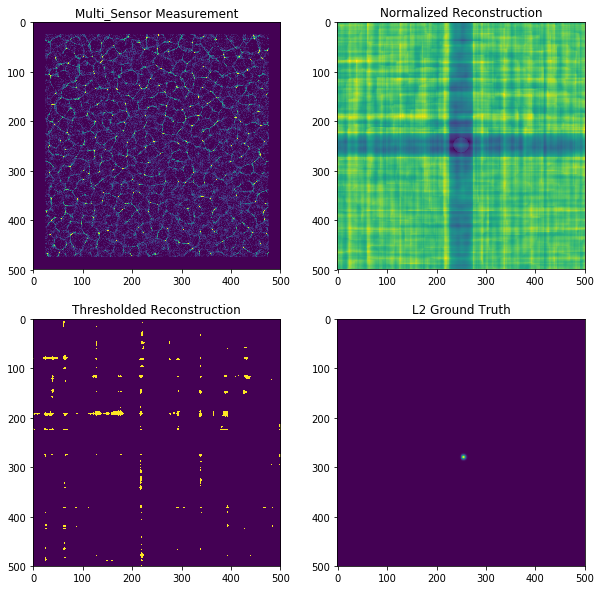

In [9]:
results = np.zeros((1,np.size(sensor_scaling)))

if applyGaussFilt:
    gt = np.zeros(np.shape(ground_truth))
    sf.gaussian_filter(ground_truth, sigma = sigma, output = gt)
else:
    gt = ground_truth

    
i = 0
while i < np.size(sensor_scaling):
    print("Sensor Config: " + str(i+1) + " of " + str(np.size(sensor_scaling)))
    sensor_size = np.round(sensor_pix * sensor_scaling[i])
    ms = maskIm(reg_measurement,sensor_size.astype(int), num_sensors)
    recon_im = grad_descent(ms, iters)
    n = LAlg.norm(recon_im - gt)
    results[0,i] = n
    print("L2-NORM -------- " + str(n))

    
    #Show the reconstruction
    plt.subplot(2,2,1), plt.imshow(ms), plt.title('Multi_Sensor Measurement')
    plt.subplot(2,2,2), plt.imshow(recon_im/np.max(recon_im)), plt.title('Normalized Reconstruction')
    plt.subplot(2,2,3), plt.imshow(recon_im > np.sort(recon_im.flatten())[-3000]), plt.title('Thresholded Reconstruction')
    plt.subplot(2,2,4), plt.imshow(gt), plt.title('L2 Ground Truth')
    
    i = i + 1
    

       

# 4) Graphing Results

Text(0,0.5,'L2 Norm')

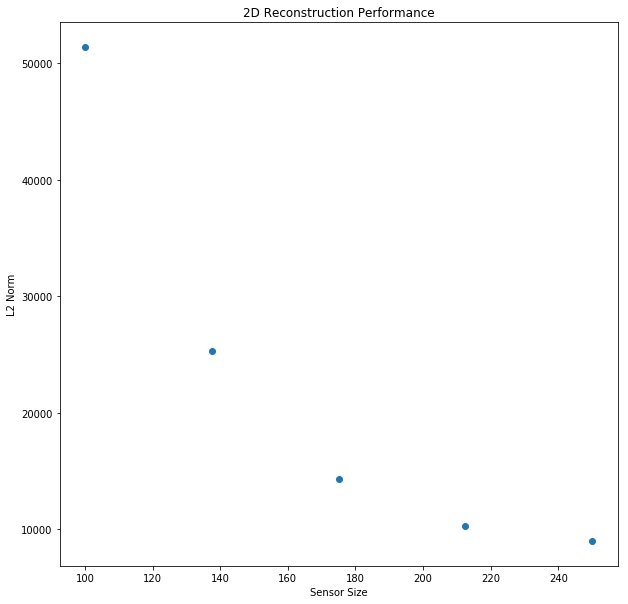

In [203]:
x = sensor_scaling * sensor_pix[0]
y = results
plt.scatter(x,y)
plt.title('2D Reconstruction Performance')
plt.xlabel('Sensor Size')
plt.ylabel('L2 Norm')

-----------------------------------------------------------------------------------------------------------------------------